Quite a while ago I did a [blog post](http://rdkit.blogspot.com/2013/12/using-allchemconstrainedembed.html) showing how to use the Python function `AllChem.ConstrainedEmbed()` to generate conformations where the positions of a set of atoms are constrained to match the coordinates of a template molecule. More recently [a question](https://www.mail-archive.com/rdkit-discuss@lists.sourceforge.net/msg08465.html) came up on the mailing list about how to use the core embedding functionality that lies underneath `AllChem.ConstrainedEmbed()`; this short post will look at that.

In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdDepictor
rdDepictor.SetPreferCoordGen(True)
IPythonConsole.molSize = (250,200)
from rdkit.Chem import AllChem
import math

We're going to work with cyclosporine here, since it's delightfully complicated, which makes it fun. :-) In this case we're going to ignore atomic stereochemistry in order to speed the conformation generation up (the RDKit tends to take a while to generate conformations for molecules with a large number of stereocenters). 

We'll also define the macrocylce as the core; this is what we're going to use to provide constraints.

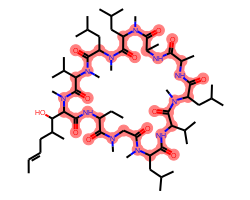

In [2]:
m = Chem.MolFromSmiles('C/C=C/CC(C)C(O)C1C(=O)NC(CC)C(=O)N(C)CC(=O)N(C)C(CC(C)C)C(=O)NC(C(C)C)C(=O)N(C)C(CC(C)C)C(=O)NC(C)C(=O)NC(C)C(=O)N(C)C(CC(C)C)C(=O)N(C)C(CC(C)C)C(=O)N(C)C(C(C)C)C(=O)N1C')
rdDepictor.Compute2DCoords(m)

core = Chem.MolFromSmiles('C1C(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)N1')
m.GetSubstructMatch(core)
m

Start by generating a conformation for cyclosporine itself.

In [3]:
mh = Chem.AddHs(m)
AllChem.EmbedMolecule(mh,randomSeed=0xf00d)

0

For the other molecule, we'll take a molecule I pulled from ChEMBL that includes the core.
I also removed stereochemistry here.

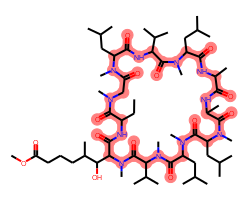

In [27]:
smi = 'CCC1NC(=O)C(C(O)C(C)CCCC(=O)OC)N(C)C(=O)C(C(C)C)N(C)C(=O)C(CC(C)C)N(C)C(=O)C(CC(C)C)N(C)C(=O)C(C)NC(=O)C(C)NC(=O)C(CC(C)C)N(C)C(=O)C(C(C)C)NC(=O)C(CC(C)C)N(C)C(=O)CN(C)C1=O'
newm = Chem.MolFromSmiles(smi)
rdDepictor.Compute2DCoords(newm)
newm.GetSubstructMatch(core)
newm

Generate an unconstrained conformation for that:

In [28]:
newmh = Chem.AddHs(newm)
AllChem.EmbedMolecule(newmh,randomSeed=0xf00d)

0

Now calculate the RMSD between the core atoms in cylosporine and in our test molecule.

In [29]:
m_match = mh.GetSubstructMatch(core)
newm_match = newmh.GetSubstructMatch(core)
delta2 = 0.0
for mi,newmi in zip(m_match,newm_match):
    d = (mh.GetConformer().GetAtomPosition(mi) - newmh.GetConformer().GetAtomPosition(newmi)).LengthSq()
    delta2 += d
print('core RMSD:',math.sqrt(delta2/len(m_match)))

core RMSD: 6.984196114755908


There's no reason to expect this RMSD to be anything other than huge: we're using different conformations of a flexible core and haven't aligned them to each other.

We can go ahead and do an alignmeent and see how that affects the RMSD:

In [30]:
AllChem.AlignMol(newmh,mh,atomMap = list(zip(newm_match,m_match)))
delta2 = 0.0
for mi,newmi in zip(m_match,newm_match):
    d = (mh.GetConformer().GetAtomPosition(mi) - newmh.GetConformer().GetAtomPosition(newmi)).LengthSq()
    delta2 += d
print('aligned core RMSD:',math.sqrt(delta2/len(m_match)))

aligned core RMSD: 2.380943358707943


Again, it's not surprising that this is a large RMSD: the core is quite flexible and we haven't constrained it at all.

Adding constraints is the point of this blog post though, so let's move onto that.

`AllChem.EmbedMolecule()` can be given constraints for the positions of certain atoms using the `coordMap` argument, which expects a dictionary that provides a `Point3D` for each atom that should have a fixed position.

In [31]:
cmap = {newm_match[i]:mh.GetConformer().GetAtomPosition(m_match[i]) for i in range(len(m_match))}
AllChem.EmbedMolecule(newmh,randomSeed=0xf00d,coordMap=cmap)
delta2 = 0.0
for mi,newmi in zip(m_match,newm_match):
    d = (mh.GetConformer().GetAtomPosition(mi) - newmh.GetConformer().GetAtomPosition(newmi)).LengthSq()
    delta2 += d
print('core RMSD:',math.sqrt(delta2/len(m_match)))

core RMSD: 2.460244777618771


Wait... what happened here? Shouldn't this number be smaller since we introduced constraints? This was the question on the mailing list.

The function `AllChem.EmbedMolecule()` uses the coordinates provided in `coordMap` to set elements of the distance bounds matrix that is used to generate conformations (details about the RDKit's distance-geometry-based conformation generator are in the [documentation](https://www.rdkit.org/docs/GettingStartedInPython.html#working-with-3d-molecules)). This results in conformations where the d

Note that, because the coordinates are being constrained using the distances between them, you should expect rigid shifts of the core atoms relative to the constraints. This is solveable by aligning the core of the test molecule to the core of the reference:

In [32]:
AllChem.AlignMol(newmh,mh,atomMap = list(zip(newm_match,m_match)))
delta2 = 0.0
for mi,newmi in zip(m_match,newm_match):
    d = (mh.GetConformer().GetAtomPosition(mi) - newmh.GetConformer().GetAtomPosition(newmi)).LengthSq()
    delta2 += d
print('aligned core RMSD:',math.sqrt(delta2/len(m_match)))

aligned core RMSD: 0.16512582920160068


Note that the output coordinates don't match the constraint coordinates exactly. This will almost always be the case; they should be close, but some differences are, unforunately, expected due to the nature of the algorithm.

*Aside 1*: while thinking about this blog post, I came up with a relatively straightforward way to force the coordinates to match exactly (and to remove the need for the alignment step) in some circumstances. Assuming it works as I expect it to, this will hopefully end up in the 2019.03 RDKit release.

*Aside 2*: if it's really important to you that the constrained coordinates exactly match the constraints, take a look at [AllChem.ConstrainedEmbed](https://www.rdkit.org/docs/source/rdkit.Chem.AllChem.html#rdkit.Chem.AllChem.ConstrainedEmbed) and that [old blog post](http://rdkit.blogspot.com/2013/12/using-allchemconstrainedembed.html) mentioned above. `AllChem.ConstrainedEmbed` does a couple of extra steps to ensure that the output coordinates of the constrained atoms match the constraint positions very closely.


It's worth taking a look at the conformations of our molecules. We'll do that using [py3Dmol](https://github.com/3dmol). There's some more info on using this with the RDKit in another [old blog post](http://rdkit.blogspot.com/2016/07/using-ipywidgets-and-py3dmol-to-browse.html).

The live widget unfortunately does not work in blogger, so I've added a screenshot. If you run the notebook for yourself, you will actually have an interactive visualization here.

In [33]:
import py3Dmol
def drawit(ms, p=None, confId=-1):
        if p is None:
            p = py3Dmol.view(width=400, height=400)
        p.removeAllModels()
        for m in ms:
            mb = Chem.MolToMolBlock(m, confId=confId)
            p.addModel(mb, 'sdf')
        p.setStyle({'stick':{}})
        p.setBackgroundColor('0xeeeeee')
        p.zoomTo()
        return p.show()

In [19]:
drawit((mh,newmh))

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol